In [1]:
%pip install diffusers
%pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 31.6 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 7.0 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
def get_models(model_name, dtype=torch.float16):
    tokenizer = CLIPTokenizer.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="text_encoder").to(dtype=dtype)
    vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae").to(dtype=dtype)
    scheduler = DDPMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")
    unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet").to(dtype=dtype)
    return tokenizer, text_encoder, vae, scheduler, unet


In [4]:
import os
import random
import pandas as pd
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class NIHChestXrayDataset(Dataset):
    def __init__(self, csv_file: Path, image_dir: Path, tokenizer):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.tokenizer = tokenizer

        # Define the image transformations
        self.train_transforms = transforms.Compose([
#             transforms.Resize((256, 256)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # Normalize to the range [-1, 1]
        ])
    
    def __len__(self):
        return len(self.data)

    def _generate_prompt(self, age, gender, diseases):
        """Generate diverse prompts based on age, gender, and disease findings."""
        gender_text = "man" if gender == "M" else "woman"
        disease_list = diseases.split('|') if diseases else ["no disease"]
        disease_text = " and ".join(disease_list)
        
        templates = [
            f"Create a chest X-ray image of a {age} years old {gender_text} with {disease_text}.",
    f"Provide an X-ray showing a {age} year-old {gender_text} with conditions like {disease_text}.",
    f"A {age}-year-old {gender_text} suffering from {disease_text}.",
    f"Generate a chest X-ray for a {age} years old {gender_text} diagnosed with {disease_text}.",
    f"Show a chest X-ray of a {age}-year-old {gender_text} experiencing {disease_text}.",
    f"Generate a medical scan for a {age}-year-old {gender_text} with signs of {disease_text}.",
    f"Display a chest X-ray for a {age} years old {gender_text} with {disease_text}.",
    f"Create a scan showing a {age}-year-old {gender_text} with a diagnosis of {disease_text}.",
    f"An X-ray revealing the chest condition of a {age} years old {gender_text} suffering from {disease_text}.",
    f"Generate a diagnostic image of a {age}-year-old {gender_text} showing {disease_text}.",
    f"Visualize the chest health of a {age} years old {gender_text} diagnosed with {disease_text}.",
    f"Create a scan that shows the {disease_text} in a {age}-year-old {gender_text}.",
    f"Present a chest X-ray for a {age} years old {gender_text} with {disease_text} symptoms.",
    f"An X-ray image for a {age}-year-old {gender_text} diagnosed with {disease_text}.",
    f"Generate a chest X-ray for a {age} years old {gender_text} displaying signs of {disease_text}.",
    f"A chest scan showing {disease_text} in a {age}-year-old {gender_text}.",
    f"Display the X-ray results of a {age} years old {gender_text} dealing with {disease_text}.",
    f"Create an X-ray of a {age}-year-old {gender_text} battling {disease_text}.",
    f"A chest X-ray showcasing {disease_text} in a {age} years old {gender_text}.",
    f"Generate an X-ray highlighting the {disease_text} in a {age}-year-old {gender_text}.",
    f"Show an X-ray of a {age} years old {gender_text} presenting with {disease_text}.",
    f"Generate a diagnostic X-ray of a {age}-year-old {gender_text} experiencing {disease_text}.",
    f"Present a medical scan of a {age} years old {gender_text} diagnosed with {disease_text}.",
    f"Show a chest X-ray for a {age}-year-old {gender_text} suffering from {disease_text}.",
    f"Create an X-ray for a {age} years old {gender_text} showing symptoms of {disease_text}.",
    f"A medical X-ray depicting {disease_text} in a {age}-year-old {gender_text}.",
    f"Generate a chest X-ray of a {age} years old {gender_text} struggling with {disease_text}.",
    f"Show the X-ray of a {age}-year-old {gender_text} diagnosed with {disease_text}.",
    f"Display a chest scan for a {age} years old {gender_text} with {disease_text} signs.",
    f"A medical X-ray for a {age}-year-old {gender_text} showing evidence of {disease_text}.",
    f"Generate a chest X-ray for a {age} years old {gender_text} diagnosed with {disease_text}.",
    f"An X-ray for a {age}-year-old {gender_text} battling {disease_text}.",
    f"Display a diagnostic scan for a {age} years old {gender_text} experiencing {disease_text}.",
    f"Create a medical X-ray for a {age}-year-old {gender_text} showing signs of {disease_text}.",
    f"A chest X-ray revealing the presence of {disease_text} in a {age} years old {gender_text}.",
    f"Generate an X-ray showing a {age}-year-old {gender_text} affected by {disease_text}.",
    f"Present a chest scan for a {age} years old {gender_text} with {disease_text}.",
    f"An X-ray image of a {age}-year-old {gender_text} diagnosed with {disease_text}.",
    f"Create an X-ray showcasing {disease_text} in a {age} years old {gender_text}.",
    f"Generate a chest X-ray for a {age}-year-old {gender_text} showing {disease_text} symptoms.",
    f"Display a scan showing the chest health of a {age} years old {gender_text} with {disease_text}.",
    f"Create a chest X-ray for a {age}-year-old {gender_text} with a condition of {disease_text}.",
    f"A chest scan showing {disease_text} in a {age} years old {gender_text}.",
    f"Generate a diagnostic scan of a {age}-year-old {gender_text} with {disease_text}.",
    f"Show an X-ray for a {age} years old {gender_text} with {disease_text} signs.",
    f"Create an X-ray depicting {disease_text} in a {age}-year-old {gender_text}.",
    f"A diagnostic chest X-ray for a {age} years old {gender_text} suffering from {disease_text}.",
    f"Present a scan of a {age}-year-old {gender_text} diagnosed with {disease_text}.",
    f"Show a medical X-ray for a {age} years old {gender_text} showing signs of {disease_text}.",
    f"An X-ray showcasing the {disease_text} in a {age}-year-old {gender_text}.",
    f"Create a detailed chest X-ray image of a {age} years old {gender_text} with the symptoms of {disease_text}.",
    f"Provide an insightful X-ray showing a {age} year-old {gender_text} suffering from conditions like {disease_text}.",
    f"A {age}-year-old {gender_text} displaying the effects of {disease_text} in their chest X-ray.",
    f"Generate a chest X-ray for a {age} years old {gender_text} diagnosed with {disease_text} recently.",
    f"Show the chest X-ray of a {age}-year-old {gender_text} with a visible condition of {disease_text}.",
    f"Create an X-ray image for a {age} years old {gender_text} who has been diagnosed with {disease_text}.",
    f"Display an X-ray that illustrates the chest condition of a {age} years old {gender_text} suffering from {disease_text}.",
    f"Generate a medical X-ray for a {age}-year-old {gender_text} experiencing symptoms related to {disease_text}.",
    f"Showcase a chest X-ray for a {age} years old {gender_text} exhibiting signs of {disease_text}.",
    f"Create a visual representation of a {age}-year-old {gender_text} with diagnosed {disease_text} in their X-ray.",
    f"An X-ray showing the chest condition of a {age} years old {gender_text} who has {disease_text}.",
    f"Generate a diagnostic image for a {age}-year-old {gender_text} with pronounced symptoms of {disease_text}.",
    f"Visualize a chest X-ray of a {age} years old {gender_text} with medical issues relating to {disease_text}.",
    f"Produce a chest scan of a {age}-year-old {gender_text} with health concerns regarding {disease_text}.",
    f"Generate an X-ray of a {age} years old {gender_text} who shows clear signs of {disease_text}.",
    f"Provide an X-ray for a {age}-year-old {gender_text} experiencing severe {disease_text}.",
    f"A chest X-ray depicting the medical condition of a {age} years old {gender_text} related to {disease_text}.",
    f"Show the X-ray results for a {age}-year-old {gender_text} who is afflicted by {disease_text}.",
    f"Create a chest X-ray image for a {age} years old {gender_text} that illustrates their {disease_text}.",
    f"Generate an insightful scan showing the {disease_text} in a {age} years old {gender_text}.",
    f"Display a diagnostic chest X-ray for a {age}-year-old {gender_text} showing symptoms of {disease_text}.",
    f"An X-ray for a {age} years old {gender_text} with visible {disease_text} in their lungs.",
    f"Show a medical image depicting a {age} years old {gender_text} with severe cases of {disease_text}.",
    f"Create a chest X-ray that highlights the {disease_text} in a {age} years old {gender_text}.",
    f"Generate an X-ray showcasing the chest of a {age}-year-old {gender_text} dealing with {disease_text}.",
    f"Present a diagnostic image of a {age} years old {gender_text} that clearly shows {disease_text}.",
    f"An X-ray for a {age}-year-old {gender_text} exhibiting clear symptoms of {disease_text}.",
    f"Display a medical X-ray showing a {age} years old {gender_text} affected by {disease_text}.",
    f"Generate a chest X-ray for a {age} years old {gender_text} who is currently suffering from {disease_text}.",
    f"Visualize the X-ray results for a {age}-year-old {gender_text} with health issues regarding {disease_text}.",
    f"Create a chest scan for a {age} years old {gender_text} diagnosed with {disease_text} recently.",
    f"Show an X-ray illustrating the chest condition of a {age} years old {gender_text} with {disease_text}.",
    f"Produce a diagnostic chest X-ray for a {age} years old {gender_text} presenting with {disease_text}.",
    f"Generate an X-ray for a {age} years old {gender_text} demonstrating health concerns related to {disease_text}.",
    f"A chest X-ray image showing a {age} years old {gender_text} affected by {disease_text}.",
    f"Display the X-ray for a {age}-year-old {gender_text} showing definitive signs of {disease_text}.",
    f"Create a detailed chest scan for a {age} years old {gender_text} who has {disease_text}.",
    f"An insightful X-ray depicting the chest condition of a {age}-year-old {gender_text} with {disease_text}.",
    f"Show a chest X-ray image for a {age} years old {gender_text} exhibiting symptoms of {disease_text}.",
    f"Generate a diagnostic chest X-ray for a {age} years old {gender_text} who shows signs of {disease_text}.",
    f"Visualize the chest health of a {age} years old {gender_text} with evident signs of {disease_text}.",
    f"Create an X-ray image depicting the health concerns of a {age}-year-old {gender_text} with {disease_text}.",
    f"Display a chest scan for a {age} years old {gender_text} diagnosed with serious cases of {disease_text}.",
    f"An X-ray showing a {age}-year-old {gender_text} suffering from {disease_text}.",
    f"Generate a medical X-ray for a {age} years old {gender_text} who presents with {disease_text}.",
    f"Show an insightful chest X-ray for a {age} years old {gender_text} with diagnosed {disease_text}.",
    f"Create a diagnostic X-ray image for a {age}-year-old {gender_text} showing signs of {disease_text}.",
    f"A chest X-ray illustrating the presence of {disease_text} in a {age} years old {gender_text}.",

        ]
        
        return random.choice(templates)

    def _parse_age(self, age_str):
        """Extract the age in years from the 'Patient Age' field."""
        if age_str.endswith("Y"):
            try:
                return int(age_str.strip("Y"))
            except ValueError:
                return None  
        return None

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Construct the full image path and check if the image exists
        image_path = os.path.join(self.image_dir, row['Image Index'])
        if not os.path.exists(image_path):
            return self.__getitem__(random.randint(0, len(self) - 1))  # Try another sample if image is missing

        
        try:
            image = Image.open(image_path).convert("RGB")
            image = self.train_transforms(image)
        except Exception as e:
            print(f"Error loading image at {image_path}: {e}")
            return self.__getitem__(random.randint(0, len(self) - 1))  
        
        
        age_str = row['Patient Age']
        age = self._parse_age(age_str)
        if age is None:
            return self.__getitem__(random.randint(0, len(self) - 1)) 

        # Get gender and disease findings
        gender = row['Patient Gender']
        if gender not in ["M", "F"]:  
            return self.__getitem__(random.randint(0, len(self) - 1))  
        
        diseases = row['Finding Labels']
        
        
        prompt = self._generate_prompt(age, gender, diseases)
        
        
        input_ids = self.tokenizer(
            prompt,
            max_length=self.tokenizer.model_max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )["input_ids"][0]  
        
        return {
            'pixel_values': image,  
            'input_ids': input_ids  
        }


from transformers import CLIPTokenizer


tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")


dataset = NIHChestXrayDataset(
    csv_file=Path('/kaggle/input/nih-chest-x-ray-14-224x224-resized/Data_Entry_2017.csv'),
    image_dir=Path('/kaggle/input/nih-chest-x-ray-14-224x224-resized/images-224/images-224'),
    tokenizer=tokenizer
)


sample = dataset[0]
print(sample['pixel_values'].shape)  
print(sample['input_ids'].shape)     


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


torch.Size([3, 224, 224])
torch.Size([77])


In [5]:
def setup_models_for_training(model_name, rank: int=256):
    tokenizer, text_encoder, vae, scheduler, unet = get_models(model_name)

    for m in (unet, text_encoder, vae):
        for p in m.parameters():
            p.requires_grad = False

    
    unet_lora_config = LoraConfig(
        r=rank,
        lora_alpha=rank,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    )

    unet.add_adapter(unet_lora_config)

    
    for p in unet.parameters():
        if p.requires_grad:
            p.data = p.to(dtype=torch.float32)

    return tokenizer, text_encoder, vae, scheduler, unet

def get_lora_params(unet):
    return [p for p in filter(lambda p: p.requires_grad, [p for p in unet.parameters()])]

In [6]:
class TrainingConfig(BaseModel):
    train_steps: int = 100
    lr: float = 1e-5
    batch_size: int = 8
    accumulation_steps: int = 4
    rank: int = 128
    max_grad_norm: float = 1.0
    pretrained_name: str = "runwayml/stable-diffusion-v1-5"
    data_dir: str = "/kaggle/input/nih-chest-x-ray-14-224x224-resized"
    snr_gamma: float = -1
    seed: int = -1

In [7]:
def train(
    tokenizer: CLIPTokenizer, 
    text_encoder: CLIPTextModel, 
    vae: AutoencoderKL, 
    scheduler: DDPMScheduler, 
    unet: UNet2DConditionModel,
    config: TrainingConfig,
    device = None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    lora_params = get_lora_params(unet)

    text_encoder.to(device).eval()
    vae.to(device).eval()
    unet.to(device).train()

    
    train_dataset = NIHChestXrayDataset(
    csv_file=Path(config.data_dir) / "Data_Entry_2017.csv",   
    image_dir=Path(config.data_dir) / "images-224/images-224",  
    tokenizer=tokenizer
)
    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

    
    steps_per_epoch = math.ceil(len(train_dataloader) / config.accumulation_steps)
    
    epochs = math.ceil(config.train_steps / steps_per_epoch)
    
    lr = config.lr * config.accumulation_steps * config.batch_size
    optimizer = torch.optim.AdamW(lora_params, lr=lr)

    scaler = torch.cuda.amp.GradScaler()

   
    global_step = 0
    progress_bar = tqdm(
        range(config.train_steps),
        desc="Steps"
    )

    print(f"configs: {config}")
    print(f"epochs: {epochs}")
    print(f"steps per epoch: {steps_per_epoch}")
    print(f"total steps: {config.train_steps}")
    print(f"accumulation steps: {config.accumulation_steps}")
    print(f"total batch size: {config.batch_size * config.accumulation_steps}")
    print(f"lr: {lr}")

    losses = []
    for _ in range(epochs):
        for step, batch in enumerate(train_dataloader):
            bs = batch["input_ids"].shape[0]

            with torch.autocast(device_type="cuda", dtype=torch.float16):
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"].to(device), return_dict=False)[0]

                timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (bs,)).long().to(device)

                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"].to(device)).latent_dist.sample()
                    latents = latents * vae.config.scaling_factor

                noise = torch.randn_like(latents)
                noisy_latents = scheduler.add_noise(latents, noise, timesteps)
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]

                if config.snr_gamma > 0:
                    
                    snr = compute_snr(scheduler, timesteps)
                    mse_loss_weights = torch.stack([snr, config.snr_gamma * torch.ones_like(timesteps)], dim=1).min(
                        dim=1
                    )[0]
                    mse_loss_weights = mse_loss_weights / snr
                    loss = F.mse_loss(noise_pred, noise, reduction="none")
                    loss = loss.mean(dim=list(range(1, len(loss.shape)))) * mse_loss_weights
                    loss = loss.mean()
                else:
                    loss = F.mse_loss(noise_pred, noise, reduction="mean")

            global_step+=1
            scaler.scale(loss).backward()

            if global_step % config.accumulation_steps == 0:
                if config.max_grad_norm > 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(lora_params, config.max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                progress_bar.update(1)

            losses.append(loss.item())

            progress_bar.set_postfix({"loss": losses[-1]})
            if global_step / config.accumulation_steps >= config.train_steps:
                break
    
    return {
        "losses": losses
    }

In [8]:
try:
    
    del models, pipe
    import gc; gc.collect()
    torch.cuda.empty_cache()
except:
    
    pass

config = TrainingConfig()
config.lr = 1e-5
config.rank = 64
config.train_steps = 1000
config.snr_gamma = 5.0
config.seed = 42

torch.manual_seed(config.seed)

models = setup_models_for_training(config.pretrained_name, rank=config.rank)

outputs = train(
    *models,
    config,
)

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

/tmp/ipykernel_30/3581095574.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

configs: train_steps=1000 lr=1e-05 batch_size=8 accumulation_steps=4 rank=64 max_grad_norm=1.0 pretrained_name='runwayml/stable-diffusion-v1-5' data_dir='/kaggle/input/nih-chest-x-ray-14-224x224-resized' snr_gamma=5.0 seed=42
epochs: 1
steps per epoch: 3504
total steps: 1000
accumulation steps: 4
total batch size: 32
lr: 0.00032


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ff870f1fe20>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



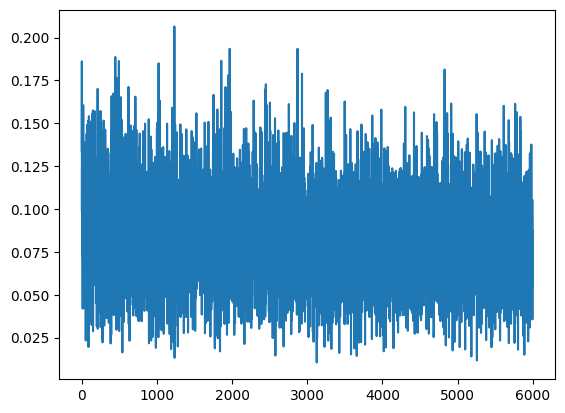

In [49]:
plt.plot(outputs["losses"])
plt.show()

In [50]:
unet = models[-1]
unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unet))

In [51]:
StableDiffusionPipeline.save_lora_weights(
    save_directory="/kaggle/working/",
    unet_lora_layers=unet_lora_state_dict,
    safe_serialization=True,
)

In [52]:
!ls -l -h /kaggle/working/pytorch_lora_weights.safetensors

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


-rw-r--r-- 1 root root 49M Nov 18 14:12 /kaggle/working/pytorch_lora_weights.safetensors


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

prompt_training = "Create a chest X-ray image of a 58 years old man with pneumonia"
prompt_new = "Show a medical X-ray for a 55 years old Man showing signs of Hernia."
num_inference_steps=500
seed = 3

In [36]:
def generate(pipeline, prompt, seed):
    generator = torch.Generator(device=device).manual_seed(seed)
    return pipeline(prompt, num_inference_steps=num_inference_steps, generator=generator).images[0]

In [37]:
pipe = DiffusionPipeline.from_pretrained(
    config.pretrained_name,
    torch_dtype=torch.float16
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [38]:
pipe.load_lora_weights("/kaggle/working/pytorch_lora_weights.safetensors")

In [40]:
pipe = DiffusionPipeline.from_pretrained(
    config.pretrained_name,
    torch_dtype=torch.float16
).to(device)

model_index.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

bert/config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-text2im-large-256/snapshots/30de525ca11a880baea4962827fb6cb0bb268955/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-text2im-large-256/snapshots/30de525ca11a880baea4962827fb6cb0bb268955/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
The config attributes {'timestep_values': None} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-text2im-large-256/snapshots/30de525ca11a880baea4962827fb6cb0bb268955/vqvae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-text2im-large-256/snapshots/30de525ca11a880baea4962827fb6cb0bb268955/vqvae

  0%|          | 0/50 [00:00<?, ?it/s]

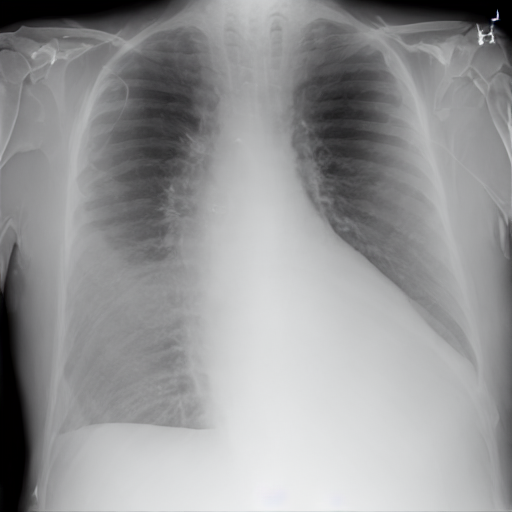

In [47]:
num_inference_steps = 50
generate(pipe, "Generate a chest X-ray image of 50 years old man suffering from Cardiomegaly.", 70)

  0%|          | 0/35 [00:00<?, ?it/s]

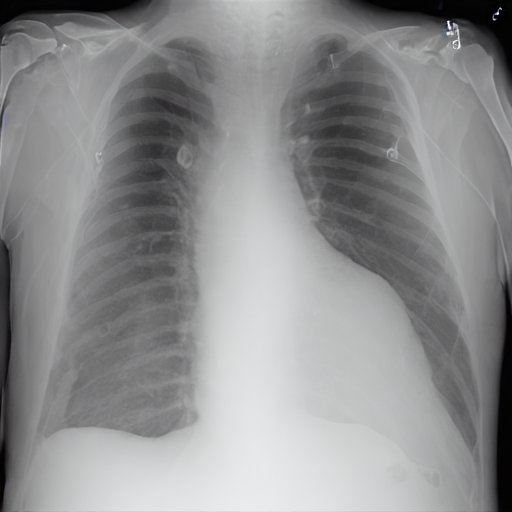

In [41]:
num_inference_steps = 35
generate(pipe, "Generate a chest X-ray image of 50 years old man suffering from effusion.", 5000)

  0%|          | 0/50 [00:00<?, ?it/s]

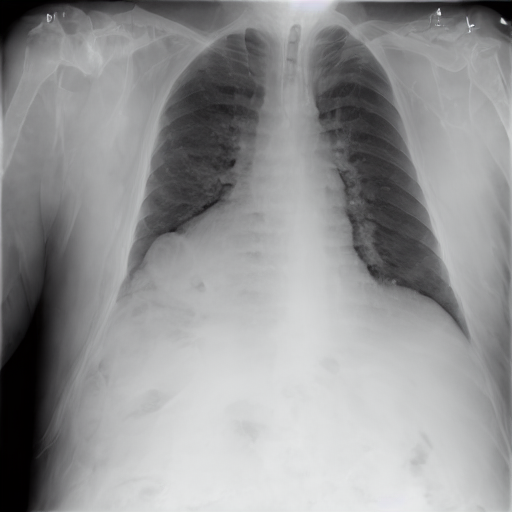

In [53]:
# With inference as 100
num_inference_steps = 50
generate(pipe, "Generate a chest X-ray image of 50 years old man suffering from Pneumonia.", 100000)

  0%|          | 0/500 [00:00<?, ?it/s]

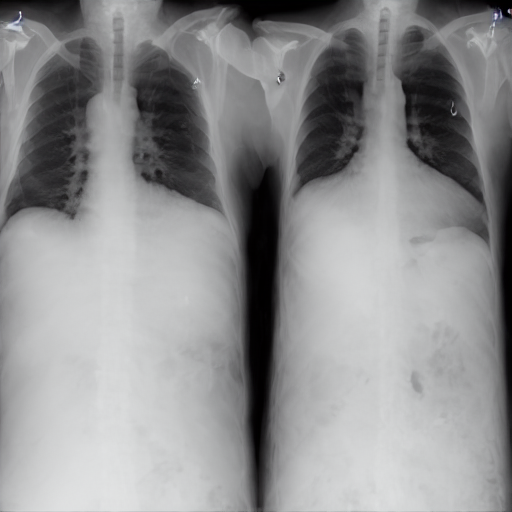

In [54]:
# With num inference as 500
num_inference_steps = 500
generate(pipe, "Generate a chest X-ray image of 50 years old man suffering from Pneumonia.", 10000)

  0%|          | 0/100 [00:00<?, ?it/s]

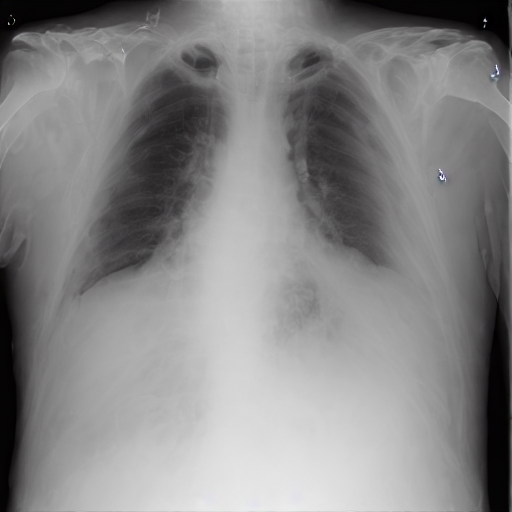

In [44]:
# With inference as 100
num_inference_steps = 100
generate(pipe, "Generate a chest X-ray image of 50 years old man suffering from Pneumonia and Hernia.", 500)

In [1]:
%pip install diffusers
%pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 32.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 7.1 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from diffusers import DiffusionPipeline


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


pretrained_model_name = "runwayml/stable-diffusion-v1-5"  
lora_weights_path = "/kaggle/input/weights/pytorch_lora_weights (1000).safetensors"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
pipe = DiffusionPipeline.from_pretrained(
    pretrained_model_name,
    torch_dtype=torch.float16  
).to(device)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
pipe.load_lora_weights(lora_weights_path)

In [5]:
def generate(pipeline, prompt, seed, num_inference_steps=35, num_images=1):
    
    if isinstance(prompt, str):
        prompt = [prompt] * num_images  
    
    images = []
    for i in range(num_images):
        
        generator = torch.Generator(device=device).manual_seed(seed + i)
        
        
        result = pipeline(prompt[i], num_inference_steps=num_inference_steps, generator=generator)
        images.append(result.images[0])
    
    return images


In [13]:
# pytorch_lora_weights (1 epoch).safetensors [Seed as 80 and num inference as 50 works best]
prompt = "Provide a chest X-ray image of 50 years old man suffering from Pneumonia"

images = generate(
    pipeline=pipe,
    prompt=prompt,
    seed=80,
    num_inference_steps=50,
    num_images=1
)

# Save generated images to disk
for i, img in enumerate(images):
    img.save(f"generated_image_{i+1}.png")
    print(f"Image saved: generated_image_{i+1}.png")



  0%|          | 0/50 [00:00<?, ?it/s]

Image saved: generated_image_1.png


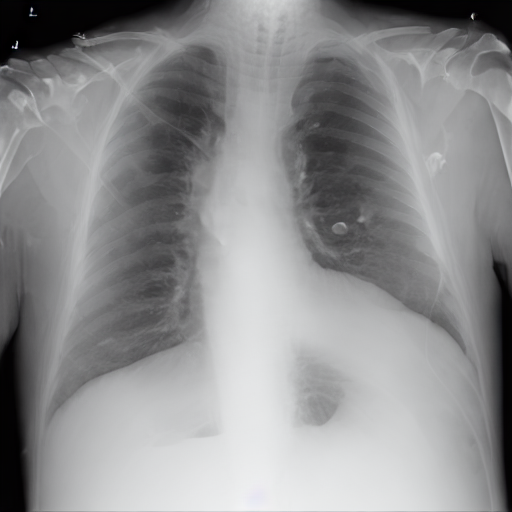

In [14]:
from IPython.display import display


for i, img in enumerate(images):
    display(img)


In [59]:
len(images)

200

In [130]:
import os
import zipfile


image_dir = "/kaggle/working/"
zip_path = "/kaggle/working/generated_images.zip"


def create_zip(image_dir, zip_path):
    with zipfile.ZipFile(zip_path, "w") as zipf:
        for root, dirs, files in os.walk(image_dir):
            for file in files:
                if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpeg"):
                    file_path = os.path.join(root, file)
                    arcname = os.path.relpath(file_path, image_dir)
                    zipf.write(file_path, arcname)
    print(f"ZIP file created at {zip_path}")


if os.path.exists(image_dir):
   
    create_zip(image_dir, zip_path)
else:
    print(f"The directory {image_dir} does not exist. Ensure images are saved there.")


from IPython.display import FileLink
FileLink(zip_path)


ZIP file created at /kaggle/working/generated_images.zip


/kaggle/working/generated_images.zip

In [24]:
import os
import shutil


working_dir = "/kaggle/working/"


def clear_working_directory(directory):
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        try:
           
            if os.path.isfile(item_path) or os.path.islink(item_path):
                os.remove(item_path)
            
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
        except Exception as e:
            print(f"Error deleting {item_path}: {e}")
    print(f"All contents of {directory} have been deleted.")


clear_working_directory(working_dir)


All contents of /kaggle/working/ have been deleted.


### FID and SSIM score calculation

In [8]:
import os
import pandas as pd
from shutil import copyfile


csv_file_path = "/kaggle/input/nih-chest-x-ray-14-224x224-resized/Data_Entry_2017.csv"  # Path to the CSV file
image_folder_path = "/kaggle/input/nih-chest-x-ray-14-224x224-resized/images-224/images-224"  # Path to the folder containing images
output_folder_path = "/kaggle/working/extracted_images/"  # Path to save extracted images


os.makedirs(output_folder_path, exist_ok=True)


metadata = pd.read_csv(csv_file_path)


disease_name = "Fibrosis"  


filtered_metadata = metadata[metadata['Finding Labels'] == disease_name]


selected_metadata = filtered_metadata.head(1)


for idx, row in selected_metadata.iterrows():
    image_name = row['Image Index']  
    image_path = os.path.join(image_folder_path, image_name)
    
    
    if os.path.exists(image_path):
        output_path = os.path.join(output_folder_path, image_name)
        copyfile(image_path, output_path)
    else:
        print(f"Image {image_name} not found, skipping.")

print(f"Extracted and saved {len(os.listdir(output_folder_path))} images to {output_folder_path}.")


Extracted and saved 3 images to /kaggle/working/extracted_images/.


In [7]:
!pip install pytorch-fid
!pip install scikit-image


In [27]:
import subprocess
import torch


if torch.cuda.is_available():
    print("GPU is available. pytorch-fid will utilize the GPU.")
else:
    print("GPU is not available. Ensure GPU is enabled in the environment settings.")


real_images_path = '/kaggle/working/extracted_images'  
generated_images_path = '/kaggle/input/evaluation-calculation/generated_images (7)'  


try:
    result = subprocess.run(
        ['python', '-m', 'pytorch_fid', real_images_path, generated_images_path],
        capture_output=True,
        text=True
    )
    print("FID Score Calculation Output:")
    print(result.stdout)
except Exception as e:
    print(f"An error occurred: {e}")


GPU is available. pytorch-fid will utilize the GPU.
FID Score Calculation Output:
FID:  187.91150774756707



In [28]:
import os
from skimage.metrics import structural_similarity as ssim
import cv2
import numpy as np


def calculate_average_ssim(real_folder, generated_folder):
    real_images = sorted(os.listdir(real_folder))
    generated_images = sorted(os.listdir(generated_folder))

    ssim_scores = []

    for real_img, gen_img in zip(real_images, generated_images):
        
        img1 = cv2.imread(os.path.join(real_folder, real_img), cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(os.path.join(generated_folder, gen_img), cv2.IMREAD_GRAYSCALE)

        
        img1 = cv2.resize(img1, (img2.shape[1], img2.shape[0]))

        
        score, _ = ssim(img1, img2, full=True)
        ssim_scores.append(score)

    
    avg_ssim = np.mean(ssim_scores)
    return avg_ssim


real_folder = '/kaggle/working/extracted_images'  
generated_folder = '/kaggle/input/evaluation-calculation/generated_images (7)'  

avg_ssim = calculate_average_ssim(real_folder, generated_folder)
print(f"Average SSIM Score: {avg_ssim}")


Average SSIM Score: 0.6028952504684693


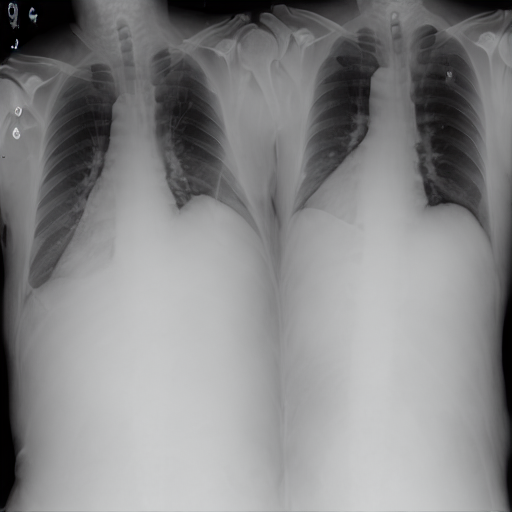

In [84]:
from IPython.display import display


for i, img in enumerate(images):
    display(img)


  0%|          | 0/50 [00:00<?, ?it/s]

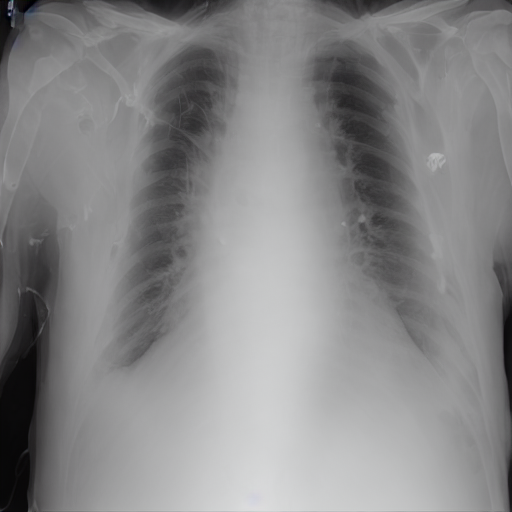

In [72]:

generate(pipe, "Generate a chest X-ray image of 50 years old man suffering from Effusion", 80, 50)

  0%|          | 0/35 [00:00<?, ?it/s]

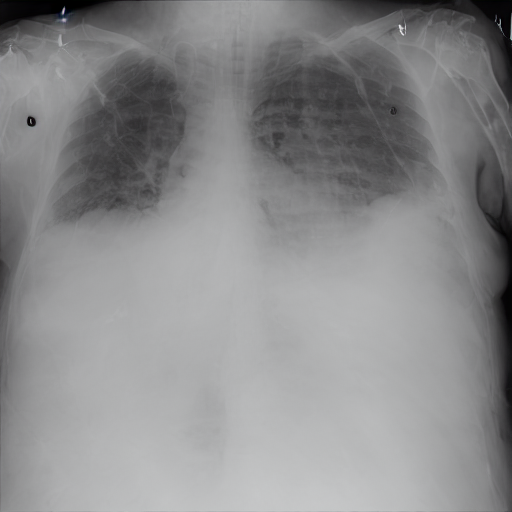

In [16]:

generate(pipe, "Generate a chest X-ray image of 50 years old man suffering from Pneumonia", 42, 35)

  0%|          | 0/150 [00:00<?, ?it/s]

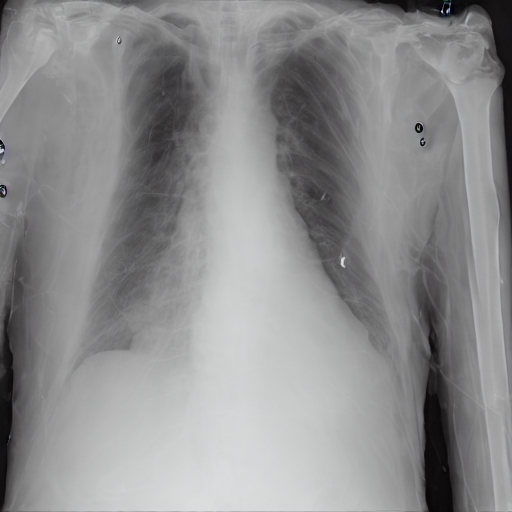

In [90]:

generate(pipe, "Provide a chest X-ray image of 50 years old man suffering from Emphysema", 200, 150)